# Example 1: Coin flipping

In this lab we will consider two data sets collected by the esteemed Professor Mittens and help her interrogate the bais in the results of coin flips.

In [1]:
import pandas as pd
from scipy import stats
import altair as alt
from typing import List, Any, Tuple
from functools import reduce
from itertools import repeat
import math as math

Since we will be working with the binomial distribution, the following function which estimates the probability based on the number of successes in a given number of trials and also a CI for this based on the Wald method will be useful

## Parameter estimation of the binomial distribution

Let $X$ be a binomial random variable (RV) which results from the number of heads when a coin is flipped $n$ times and the probability of coming up heads is $p$. For the time being we will assume that $n$ is know. The expected value of $X$ is $np$. So a simple way to estimate $p$ is to divide the number of heads, $X$, by the number of flips, $n$. This gives the estimate 

$$
\hat{p} = X / n.
$$

It turns out that this is a very sensible thing to do. The resulting estimate is called the maximum likelihood estimate (MLE) of $p$.

Given an estimator though, we want to know how confident we are in this estimate. Here we will use the Wald method to get the $95\%$ CI. It is a very simple method but is acceptable when we have a fair bit of data. The estimated standard error of $\hat{p}$ is $\sqrt{\hat{p}(1-\hat{p})/n}$, so the Wald CI is given by

$$
\hat{p} \pm z \sqrt{\frac{\hat{p}(1-\hat{p})}{n}}
$$

where $z$ is the appropriate quantile of the standard normal distribution. In the case of a $95\%$ distribution this is just $1.96$.

This is stated on the [wikipedia](https://en.wikipedia.org/wiki/Binomial_distribution#Estimation_of_parameters) but there is also a reasonably clear description in [All of Statistics](https://link.springer.com/book/10.1007/978-0-387-21736-9) which you can get via SOLO.

### Exercise 1

Implement a function called `wald_estimate_and_ci` which takes two arguments: `num_trials` which is $n$ in the description above, and `num_success` which is $X$ above. The function should return `(p_hat,(wald_lower,wald_upper))` where `p_hat` is $\hat{p}$ and `wald_x` are the limits on the $95\%$ CI using the Wald method.

In [2]:
CI = Tuple[float,float]
EstimateAndCI = Tuple[float,CI]

def wald_estimate_and_ci(num_trials: int, num_success: int) -> EstimateAndCI:
    p_hat = num_success / num_trials
    z = 1.96
    delta = z * math.sqrt(p_hat * (1 - p_hat) / num_trials)
    return (p_hat,(p_hat - delta, p_hat + delta))

### Exercise 2 part I

Look up how to simulate a random variable from a binomial distribution (it tells you [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html#scipy.stats.binom) if you want to use `scipy`). Then simulate a binomial random variable with $n=100$ and $p=0.6$. Then use the value and the `wald_estimate_and_ci` function to see how well you can estimate $p$. Write a couple of sentences to explain this.

### Exercise 2 part II

Repeat the process about 100000 times and see what proportion of the CIs capture the true value of $p$. Is it what you expect? Write a couple of sentences to explain what you found.

In [3]:
rand_xs = stats.binom.rvs(n = 100, p = 0.6, size = 100000)

def ci_contains_value(ci: CI, p: float) -> bool:
    lower,upper = ci
    return lower < p and p < upper

p_in_ci_bools = [ci_contains_value(wald_estimate_and_ci(100, x)[1], 0.6) for x in rand_xs]

reduce(lambda a, b: a + 1 if b else a, p_in_ci_bools, 0) / 100000

0.9484

## Central limit theorem

The central limit theorem tells us about the limiting distribution of the sample mean for distribution for an IID sample with a finite variance. 

### Exercise 2 (again?)

To see that the distribution of the sample mean converges to a normal distribution we will do a simulation study and compare the results with a Q-Q plot to see if it looks normally distributed. This will also demonstrate how to construct a Q-Q plot from first principles, not that you really want to do that. Anyway try to follow the steps and see how you go.

1. Write down the distribution of the sample mean given an IID sample of exponential random variables
2. Generate 100 sample means each based on a sample of 100 exponential random variables
3. Make a histogram and a Q-Q plot to see if the sample means do appear to follow a normal distribution

In [4]:
sample_size = 1000
num_replicates = 1000

sample_means = [stats.expon.rvs(scale = 5, size = sample_size).mean() for _ in range(num_replicates)]

plot_df = pd.DataFrame({"sample_mean": sample_means})

mesh_size = 100
x_vals = [0.02 * ix + 4 for ix in range(0,mesh_size)]

clt_scale = 5 / math.sqrt(sample_size)

clt_pdf = [mesh_size * stats.norm.pdf(x, loc = 5, scale = clt_scale) for x in x_vals]
clt_df = pd.DataFrame({"x": x_vals, "pdf": clt_pdf})

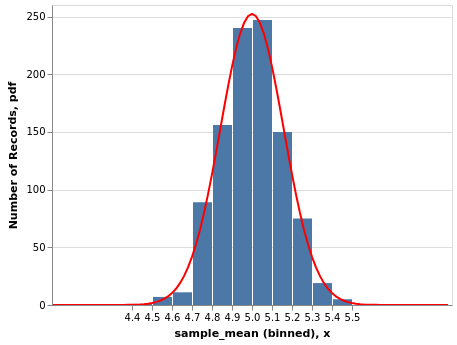

In [5]:
data_hist = (alt
                .Chart(plot_df)
                .mark_bar()
                .encode(x = alt.X("sample_mean:Q",
                                  bin = alt.BinParams(step = 0.1)),
                        y = alt.Y("count()")))

clt_line = (alt
               .Chart(clt_df)
               .mark_line(color = "red")
               .encode(x = "x",
                       y = "pdf"))

data_hist + clt_line

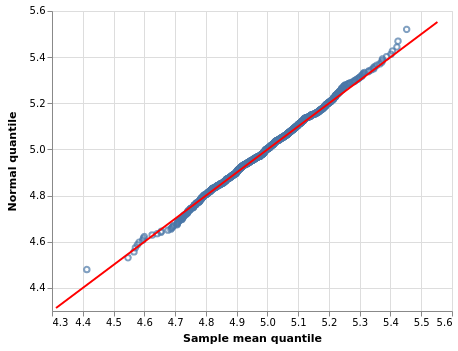

In [6]:
unit_mesh = [1 - (1 / len(sample_means)) * ix - (0.5 / len(sample_means)) for ix in range(0,len(sample_means))]
quantile_vals = [stats.norm.isf(u, loc = 5, scale = clt_scale) for u in unit_mesh]
sample_means.sort()
quant_df = pd.DataFrame({
    "sample_means": sample_means,
    "quantiles": quantile_vals})

ab_lims = [min(sample_means)-0.1, max(sample_means)+0.1]
abline_df = pd.DataFrame({"x": ab_lims, "y": ab_lims})

quant_points = (alt
                   .Chart(quant_df)
                   .mark_point()
                   .encode(x =  alt.X('sample_means:Q',
                                      scale=alt.Scale(zero=False),
                                      title = "Sample mean quantile"),
                           y = alt.Y('quantiles:Q',
                                      scale=alt.Scale(zero=False),
                                      title = "Normal quantile")))

ab_line = (alt
          .Chart(abline_df)
          .mark_line(color = "red")
          .encode(x = "x", y = "y"))

quant_points + ab_line

## Experiment 1

Professor Mittens asked 15 of her students to each take turns flipping a coin 30 times and recording how many heads they got. She has some suspicions that some of the students did not actually do this properly. We will help Mittens work out whether the coin that was used was fair, i.e. has an equal chance of showing heads or tails.

### Exercise 3 part I

Read the data in `experiement1.csv` into a `DataFrame`.

### Exercise 3 part II

Compute the point estimate and CI using the function you wrote above. Write a sentence explaining whether you think the coin is a _fair_ coin.

### Exercise 3 part III

Generate a histogram of the number of heads from each student. As an extension, include the binomial distribution supported by your estimate that is most amenable to large value outcomes.

In [7]:
exp1 = pd.read_csv("experiment1.csv")

In [8]:
head_counts = exp1.drop(columns="flip_number").groupby("name").sum()
head_counts["name"] = head_counts.index.copy()

total_heads = int(head_counts["outcome"].sum())
num_people = int(head_counts["name"].unique().size)
num_flips = int(exp1["name"].value_counts().unique())

est_and_ci = wald_estimate_and_ci(num_success=total_heads, 
                                  num_trials=num_people * num_flips)

print(est_and_ci)

(0.49333333333333335, (0.44713979693549655, 0.5395268697311701))


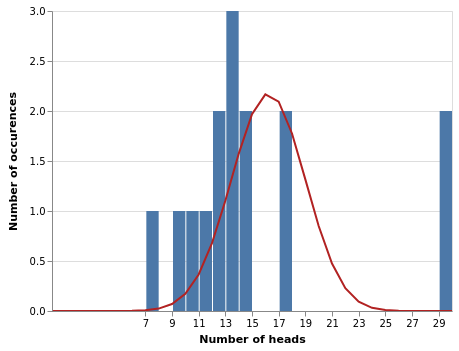

In [9]:
fig_1_a = (alt
           .Chart(head_counts)
           .mark_bar()
           .encode(alt.X("outcome:Q",
                         bin = alt.BinParams(step = 1),
                         title = "Number of heads"),
                   y = alt.Y("count()",
                            title = "Number of occurences")))

k_vals = range(0,31)
k_probs = [num_people * stats.binom.pmf(k = k, n = num_flips, p = 0.540) for k in k_vals]
binom_dist_df = pd.DataFrame({"value": k_vals,
                              "prob": k_probs})

fig_1_b = (alt
           .Chart(binom_dist_df)
           .mark_line(color= "firebrick")
           .encode(x = "value", 
                   y = "prob"))


fig_1_a + fig_1_b

### Exercise 4 part I

It looks like there might be a couple of strange points in this dataset as Mittens suspected. Using the upper bound on $p$ calculate the probability of someone getting all heads. Write a couple of sentences explaining whether you think it is reasonable to remove those data points.

### Exercise 4 part II

Remove the outliers and repeat the process of plotting the data and estimating the parameters and CI. Once you have done this, plot the distribution of the estimated binomial distribution on top of the histogram. Write a couple of sentences explaining what you think about the coin now.

In [10]:
stats.binom.pmf(k = 30, n = 30, p = 0.54)

9.371579521404065e-09

In [11]:
head_counts_clean = head_counts.loc[head_counts["outcome"] < 30]

total_heads_clean = int(head_counts_clean["outcome"].sum())
num_people_clean = int(head_counts_clean["name"].unique().size)

wald_estimate_and_ci(num_success=total_heads_clean, num_trials=num_people_clean * num_flips)

(0.4153846153846154, (0.3664761437453554, 0.4642930870238754))

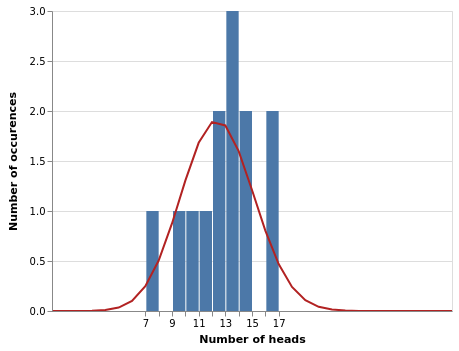

In [12]:
k_vals = range(0,31)
k_probs = [num_people_clean * stats.binom.pmf(k = k, n = num_flips, p = 0.415) for k in k_vals]
binom_dist_df = pd.DataFrame({"value": k_vals,
                              "prob": k_probs})

fig_2_a = (alt
           .Chart(head_counts_clean)
           .mark_bar()
           .encode(alt.X("outcome:Q",
                         bin = alt.BinParams(step = 1),
                         title = "Number of heads"),
                   y = alt.Y("count()",
                            title = "Number of occurences")))

fig_2_b = (alt
           .Chart(binom_dist_df)
           .mark_line(color= "firebrick")
           .encode(x = "value", y = "prob"))

fig_2_a + fig_2_b

## Experiment 2

After the success of her first experiment, Mittens was awarded funds to obtain an additional 49 coins and repeat the experiment to gather more data about the fascinating topic of coin bias. Now she gives each of 50 students a coin each and asks them to flip the coin 30 times and record the results. We will help Mittens work out whether the coins are fair.

### Excercise 5 part I

Do we need to change anything about how we analyse this data? If so, why, if not, why not? **Hint:** there are good arguments that can be given for each answer. Once you have answered one way, try to answer the other way.

### Exercise 5 part II

Using the data in `experiment2.csv` explore the data set using the methodology devised above and write a couple of sentences to explain what you found.

### Exercise 5 part III (Extension)

Consider how you might analyse this data. Over the following weeks you will learn a couple of approaches.

In [13]:
exp2 = pd.read_csv("experiment2.csv")

head_counts = exp2.drop(columns="flip_number").groupby("name").sum()
head_counts["name"] = head_counts.index.copy()

total_heads = int(head_counts["outcome"].sum())
num_people = int(head_counts["name"].unique().size)
num_flips = int(exp2["name"].value_counts().unique())

wald_estimate = wald_estimate_and_ci(num_success=total_heads, 
                                     num_trials=num_people * num_flips)

print(wald_estimate)

(0.4013333333333333, (0.37652739859779666, 0.42613926806887))


18.69224489795919 7.2079466666666665


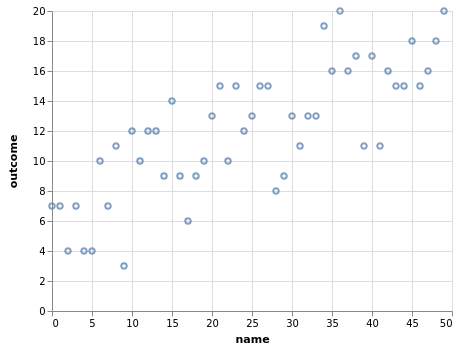

In [14]:
emp_var = head_counts["outcome"].var()
thry_var = stats.binom.var(n = num_flips, p = wald_estimate[0])

print(emp_var,thry_var)

alt.Chart(head_counts).mark_point().encode(
    x = "name",
    y = "outcome"
)